# 0. Imports and settings

## Imports

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import inflection


from scipy                 import stats as ss
from boruta                import BorutaPy
from tabulate              import tabulate
from ipywidgets            import widgets, fixed
from matplotlib            import gridspec
from matplotlib            import pyplot as plt
from IPython.core.display  import HTML

from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## Settings & Helper functions

In [3]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (((k-1) * (r-1)) / (n-1)))
    
    kcorr = k - (((k-1)**2) / (n-1))
    rcorr = r - (((r-1)**2) / (n-1))

    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 9]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 1. Data pre-processing

## 1.1 Load data

In [4]:
df1 = pd.read_csv('datasets//train.csv', low_memory=False)
df2 = pd.read_csv('datasets//store.csv', low_memory=False)
#
df3 = pd.merge(df1, df2, how='left', on='Store')
df3.sample(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
156685,586,5,2015-03-13,12040,1949,1,0,0,0,a,c,250.0,10.0,2008.0,0,NaN,NaN,NaN
154876,1007,7,2015-03-15,0,0,0,0,0,0,c,c,4180.0,9.0,2012.0,0,NaN,NaN,NaN
484342,103,3,2014-04-23,4089,386,1,0,0,1,d,c,5210.0,5.0,2015.0,0,NaN,NaN,NaN
208909,405,7,2015-01-25,0,0,0,0,0,0,a,a,1080.0,4.0,2008.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
629980,791,6,2013-12-14,6395,618,1,0,0,0,a,a,5950.0,4.0,2007.0,0,NaN,NaN,NaN
360876,176,3,2014-08-20,5775,708,1,1,0,0,a,a,3770.0,NaN,NaN,0,NaN,NaN,NaN
891419,205,2,2013-04-23,8731,1082,1,1,0,0,a,a,110.0,12.0,2007.0,0,NaN,NaN,NaN
249799,392,3,2014-12-17,10549,841,1,1,0,0,a,a,2120.0,NaN,NaN,0,NaN,NaN,NaN
534779,365,7,2014-03-09,0,0,0,0,0,0,c,a,2410.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
53440,1036,7,2015-06-14,0,0,0,0,0,0,d,c,9560.0,NaN,NaN,1,36.0,2013.0,"Jan,Apr,Jul,Oct"


### 1.1.1 Data dict

In [5]:
data_dict = [['VARIÁVEL', 'TIPO', 'INFORMAÇÃO'],
             ['store','int64', 'ID único da loja'],
             ['day_of_week','int64','Dia da semana em que as vendas ocorreram (Segunda-feira = 1)'],
             ['date','datetime64[ns]', 'Data em que as vendas ocorreram'],
             ['sales','int64', 'Volume de vendas em euros'],
             ['customers','int64', 'Quantidade de clientes que compraram naquele dia e naquela loja'],
             ['open','int64', 'Indica se a loja estava aberta naquele dia. (0 para fechada, 1 para aberta)'],
             ['promo','int64', 'Indica se a loja está praticando alguma promoção naqueel dia'],
             ['state_holiday','object', 'Indica feriado estadual. (a = feriado, b = Páscoa, c = Natal, 0 = nenhum)'],
             ['school_holiday','int64', 'Indica se a loja foi afetada pelo fechamento das escolas (0 = dia normal, 1 = feriado)'],
             ['store_type','object', 'Diferencia entre quatro modelos de lojas diferentes, (a, b, c, d)'],
             ['assortment','object', 'Descreve um nível de sortimento: a = básico, b = extra e c = estendido'],
             ['competition_distance','float64', 'distância em metros até o concorrente mais próximo'],
             ['competition_open_since_month','float64', 'Informa o mês aproximado em que o concorrente mais próximo foi aberto'],
             ['competition_open_since_year','float64', 'Informa o ano aproximado em que o concorrente mais próximo foi aberto'],
             ['promo2','int64', 'Promoção contínua para algumas lojas. 0 = não participa, 1 = participa'],
             ['promo2_since_week','float64', 'Informa a semana do ano em que a loja começou a participar da promo2'],
             ['promo2_since_year','float64', 'Informa o ano em que a loja começou a participar da promo2'],
             ['promo_interval','object', 'Indica os meses de início da promo2']]

print(tabulate(data_dict, headers='firstrow'))

VARIÁVEL                      TIPO            INFORMAÇÃO
----------------------------  --------------  --------------------------------------------------------------------------------------
store                         int64           ID único da loja
day_of_week                   int64           Dia da semana em que as vendas ocorreram (Segunda-feira = 1)
date                          datetime64[ns]  Data em que as vendas ocorreram
sales                         int64           Volume de vendas em euros
customers                     int64           Quantidade de clientes que compraram naquele dia e naquela loja
open                          int64           Indica se a loja estava aberta naquele dia. (0 para fechada, 1 para aberta)
promo                         int64           Indica se a loja está praticando alguma promoção naqueel dia
state_holiday                 object          Indica feriado estadual. (a = feriado, b = Páscoa, c = Natal, 0 = nenhum)
school_holiday                i

## 1.2 Data cleaning

In [6]:
data1 = df3.copy()

### 1.2.1 Rename columns

In [7]:
old_cols = list(data1.columns)

snakecase = lambda x: inflection.underscore(x)

new_cols = list(map(snakecase, old_cols))

data1.columns = new_cols

### 1.2.2 Data size

In [8]:
print(f'Nº de linhas: {data1.shape[0]}')
print(f'Nº de colunas: {data1.shape[1]}')

Nº de linhas: 1017209
Nº de colunas: 18


### 1.2.3 Data types adjustment

In [9]:
data1['date'] = pd.to_datetime(data1['date'])

### 1.2.4 NAN verification

In [10]:
data1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [11]:
# Assumption #1
data1['competition_distance'] = data1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

# Assumption #2
data1['competition_open_since_month'] = data1['competition_open_since_month'].apply(lambda x: 1 if math.isnan(x) else x)
data1['competition_open_since_year'] = data1['competition_open_since_year'].apply(lambda x: 1900 if math.isnan(x) else x)

# Assumption #3
data1['promo2_since_week'] = data1['promo2_since_week'].apply(lambda x: 1 if math.isnan(x) else x)
data1['promo2_since_year'] = data1['promo2_since_year'].apply(lambda x: 1 if math.isnan(x) else x)

# Conversão de mês ordinal para nomeado
month_dict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
data1['promo_interval'] = data1['promo_interval'].fillna(0)
data1['month_dict'] = data1['date'].dt.month.map(month_dict)

# Verifica participação na campanha (0 = não, 1 = sim)
data1['in_promo2'] = data1[['promo_interval', 'month_dict']].apply(lambda x: 0 if x['promo_interval'] == 0
                                                                             else 1 if x['month_dict'] in x['promo_interval'].split(',')
                                                                             else 0, axis=1)

### 1.2.5 Data readjustment

In [12]:
data1['competition_open_since_month'] = data1['competition_open_since_month'].astype('int64')
data1['competition_open_since_year'] = data1['competition_open_since_year'].astype('int64')
data1['promo2_since_week'] = data1['promo2_since_week'].astype('int64')
data1['promo2_since_year'] = data1['promo2_since_year'].astype('int64')


## 1.3 Descriptive statistic

### 1.3.1 Numerical attributes

In [13]:
# Seperando entre variáveis numéricas e categóricas
num_attributes = data1.select_dtypes(include=['int64', 'float64'])
cat_attributes = data1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

# Medidas de tendência central
mean = pd.DataFrame(num_attributes.apply(np.mean)).T
median = pd.DataFrame(num_attributes.apply(np.median)).T

# Medidas de dispersão

min_ = pd.DataFrame(num_attributes.apply(min)).T
max_ = pd.DataFrame(num_attributes.apply(max)).T
range_ = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
std_dev = pd.DataFrame(num_attributes.apply(np.std)).T
skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# unindo os dfs criados

desc_stat = pd.concat([min_, max_, range_, mean, median, std_dev, skew, kurtosis]).T.reset_index()
desc_stat.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std_deviation', 'skew', 'kurtosis']
desc_stat

,attributes,min,max,range,mean,median,std_deviation,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,5.244756,4.0,3.928520,0.311511,-1.422995
9,competition_open_since_year,1900.0,2015.0,115.0,1974.140034,2006.0,50.853208,-0.760248,-1.398719


### 1.3.2 Categorical attributes

In [14]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_dict        12
dtype: int64

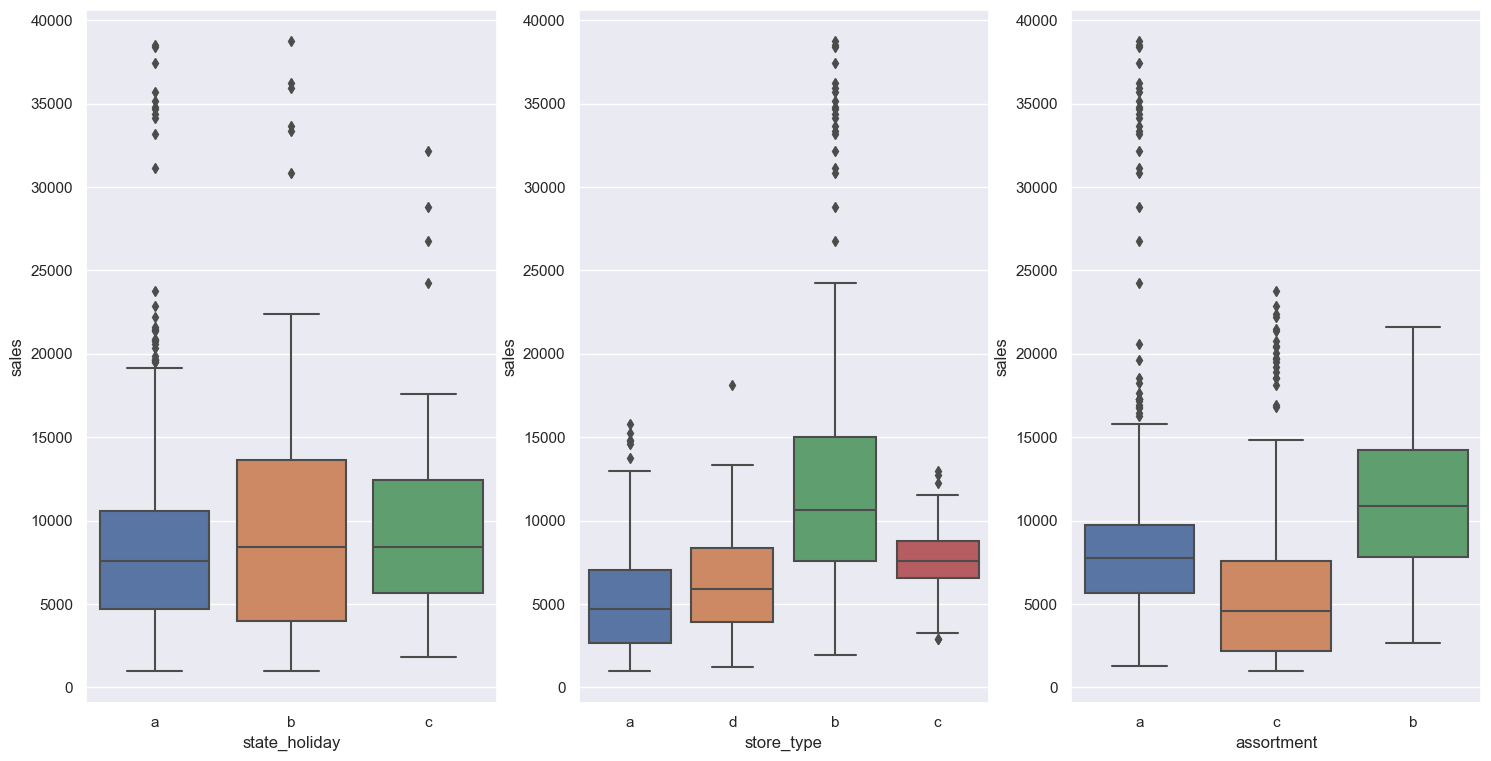

In [15]:
# Filtrando as linhas em que há feriados e vendas são maior do que zero
aux1 = data1[(data1['state_holiday'] != '0') & (data1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(data=aux1, x='state_holiday', y='sales')

plt.subplot(1, 3, 2)
sns.boxplot(data=aux1, x='store_type', y='sales')

plt.subplot(1, 3, 3)
sns.boxplot(data=aux1, x='assortment', y='sales');

# 2. Feature Engineering

In [16]:
data2 = data1.copy()

## 2.1 Mindmap de Hipóteses

1. A Abertura de um concorrente próximo não tem impacto sobre a média de vendas.

2. Lojas com ticket médio menor tem volume de vendas médio maior.

3. Lojas com ticket médio menor tem maior número de clientes.

4. Lojas que participam da promoção estendida vendem mais do que aquelas que não participam.

5. As lojas vendem mais durante o inverno.

6. Lojas vendem mais durante os feriados escolares.

7. O ticket médio de lojas com assortment superior é maior.

8. As lojas vendem mais às sextas-feiras e sábados.

9. As lojas vendem mais durante o mês de início da promo2 (os meses indicados em 'promo_interval' são os iniciais).

10. Lojas com maior variedade de produtos (assortment) vendem mais.

11. A diferença entre modelos de loja (store_type) não interfere no volume médio de vendas.

12. Lojas com sortimento mais simples tem menor número de clientes.

## 2.2 Criação das features necessárias

In [17]:
# Ticket médio
data2['avg_ticket'] = round(data2['sales'] / data2['customers'], 2)

# Tempo de competição
data2['competition_open'] = data2.apply(lambda x: '01' + '-' + str(x['competition_open_since_month']) + '-' + str(x['competition_open_since_year']), axis=1)
data2['competition_open'] = pd.to_datetime(data2['competition_open'], dayfirst=True)
data2['competition_time_open'] = ((data2['date'] - data2['competition_open'])/np.timedelta64(1 , 'M')).astype(int)

# Year Season
data2['year'] = data2['date'].dt.year
data2['month'] = data2['date'].dt.month
data2['day'] = data2['date'].dt.day

data2['month'] = data2['month'].map(month_dict)
data2['season_of_sale'] = data2['month'].apply(lambda x: 'winter' if (x == 'Dec') | (x == 'Jan') | (x == 'Feb') else
                                                   'spring' if (x == 'Mar') | (x == 'Apr') | (x == 'May') else
                                                   'fall' if (x == 'Jun') | (x == 'Jul') | (x == 'Aug') else
                                                   'summer')

# Average Ticket store_status
aux = data2[['store', 'avg_ticket']].groupby('store').mean().reset_index()
aux2 = pd.merge(data2, aux, how='inner', on='store')
aux2 = aux2.rename(columns={'avg_ticket_y':'store_avg_ticket', 'avg_ticket_x':'avg_ticket' })
data2 = aux2.copy()

# rename info
data2['assortment'] = data2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
data2['state_holiday'] = data2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 
                                                                'easter_holiday' if x == 'b' else 
                                                                'christmas' if x =='c' else 'regular_day')



## 2.3 Filtragem das linhas

In [18]:
data_aux = data2.copy()
data_aux = data_aux[data_aux['open'] != 0]

## 2.4 Filtragem das colunas

In [19]:
cols_to_drop = ['competition_open_since_month', 
                'competition_open_since_year', 
                'promo2_since_week', 
                'promo2_since_year', 
                'promo_interval', 
                'month_dict',]

data_aux = data_aux.drop(cols_to_drop, axis=1)

# 3. Análise Exploratória

In [20]:
data3 = data_aux.copy()

## 3.1 Análise Univariada

### 3.1.1 Variável resposta

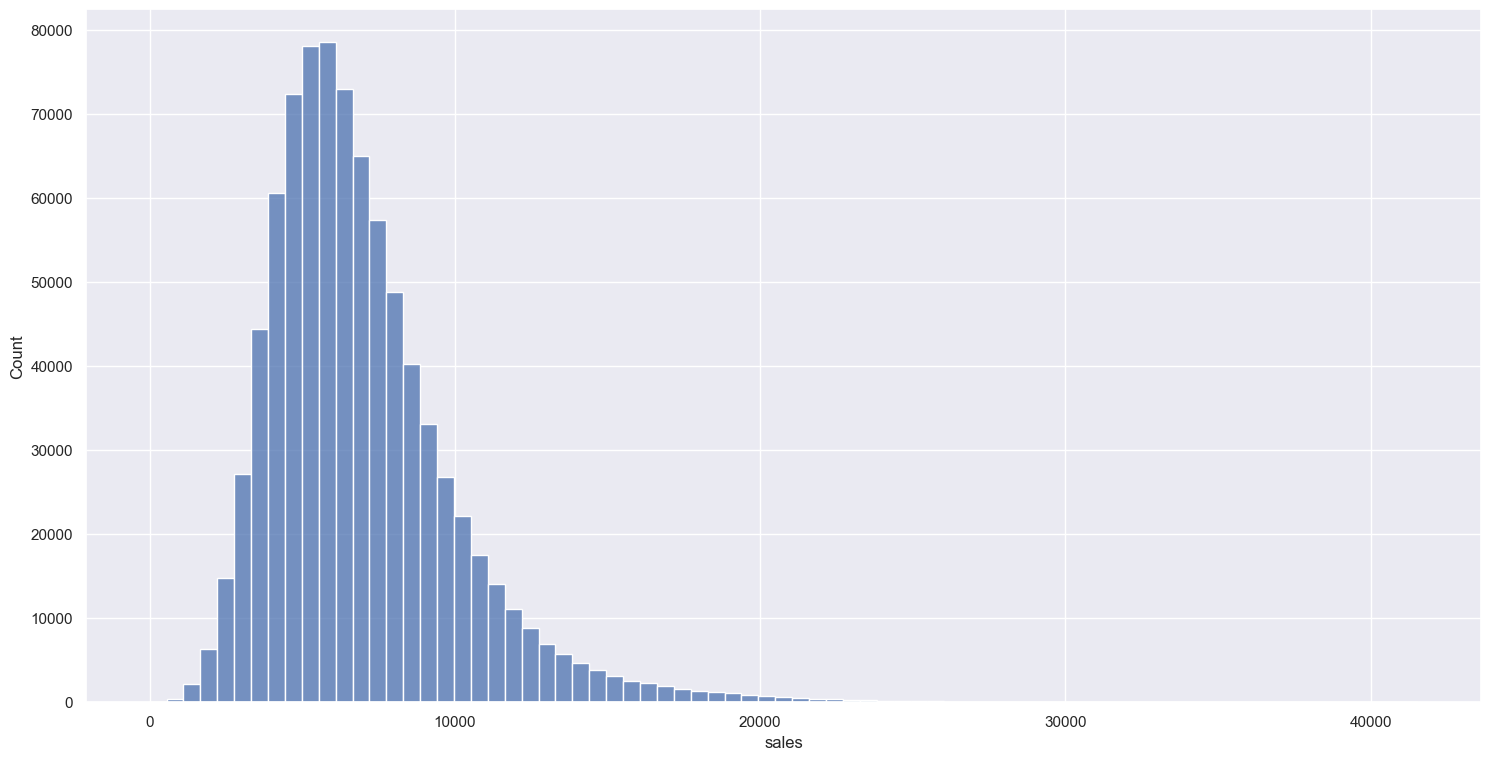

In [21]:
sns.histplot(data3['sales'], kde=False, bins=75);

### 3.1.2 Numeric Variables

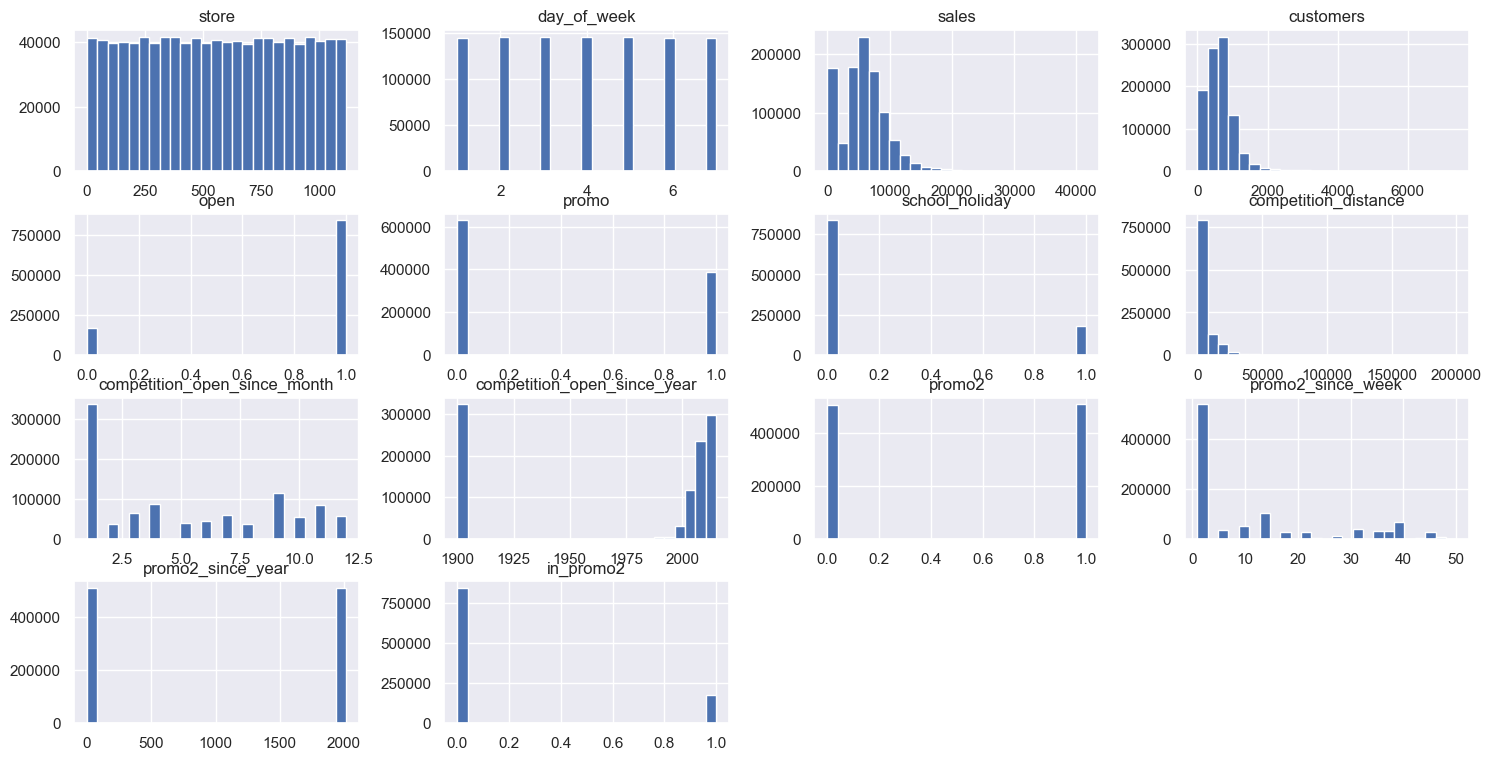

In [22]:
num_attributes.hist(bins=25);

### 3.1.3 Categorical variables

<AxesSubplot: xlabel='sales', ylabel='Density'>

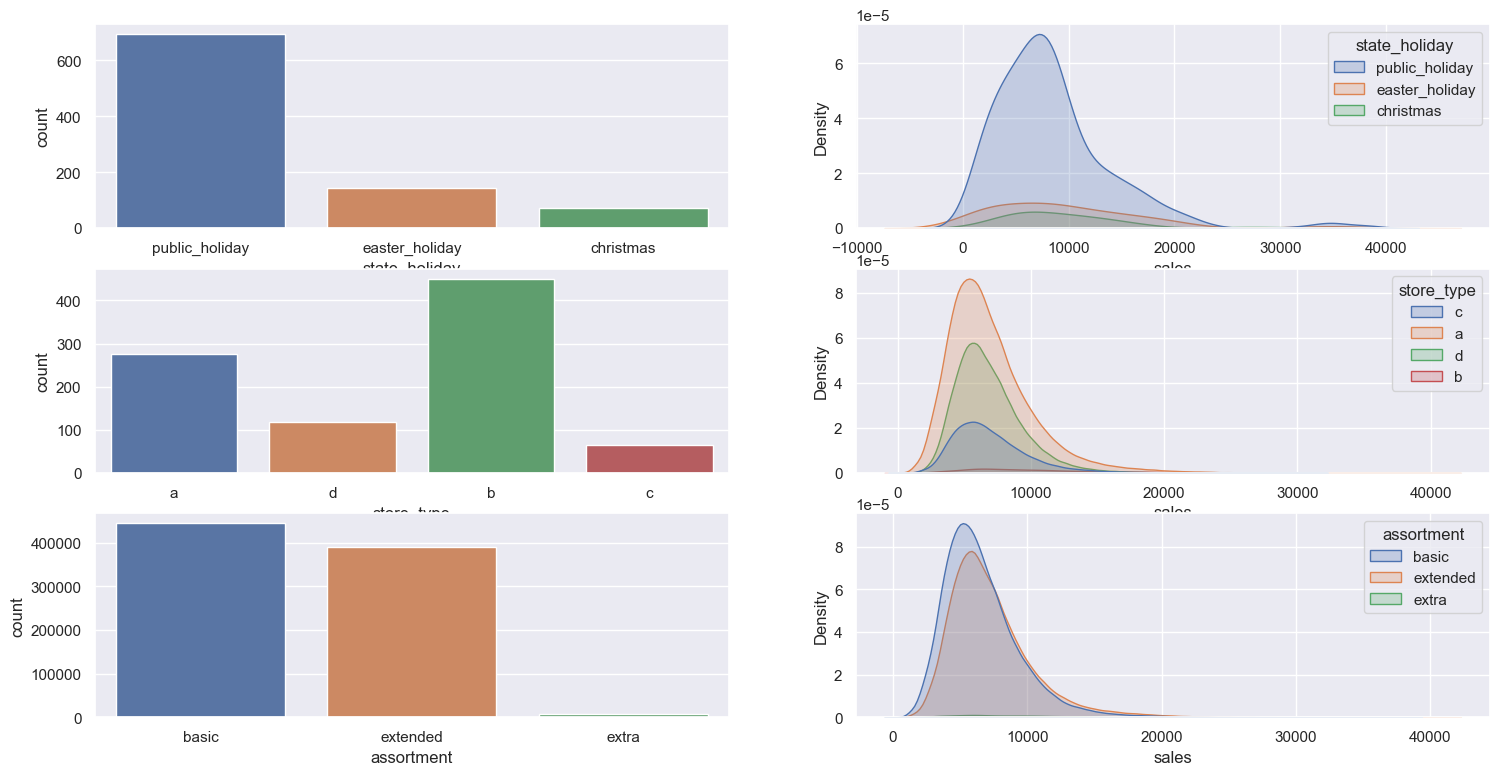

In [23]:
plt.subplot(3,2,1)
aux = data3[data3['state_holiday'] != 'regular_day']
sns.countplot(data=aux, x='state_holiday');

plt.subplot(3,2,2)
#aux1 = data3[['state_holiday', 'sales']][(data3['state_holiday'] != 'regular_day') & (data3['sales'] > 0)]
aux1 = data3[(data3['state_holiday'] != 'regular_day') & (data3['sales'] > 0) & (data3['open'] != 0)][['state_holiday', 'sales']]
sns.kdeplot(data=aux1, x='sales', hue='state_holiday', fill=True)

plt.subplot(3,2,3)
sns.countplot(data=aux, x='store_type')

plt.subplot(3,2,4)
aux2 = data3[(data3['sales'] > 0) & (data3['open'] != 0)][['store_type', 'sales']]
sns.kdeplot(data=aux2, x='sales', hue='store_type', fill=True)

plt.subplot(3,2,5)
sns.countplot(data=data3, x='assortment')

plt.subplot(3,2,6)
aux3 = data3[(data3['sales'] > 0) & (data3['open'] != 0)][['assortment', 'sales']]
sns.kdeplot(data=aux3, x='sales', hue='assortment', fill=True)

## 3.2 Análise Bivariada

In [24]:
data3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,promo2,in_promo2,avg_ticket,competition_open,competition_time_open,year,month,day,season_of_sale,store_avg_ticket
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,0,0,9.48,2008-09-01,82,2015,Jul,31,fall,8.393035
1,1,4,2015-07-30,5020,546,1,1,regular_day,1,c,basic,1270.0,0,0,9.19,2008-09-01,82,2015,Jul,30,fall,8.393035
2,1,3,2015-07-29,4782,523,1,1,regular_day,1,c,basic,1270.0,0,0,9.14,2008-09-01,82,2015,Jul,29,fall,8.393035
3,1,2,2015-07-28,5011,560,1,1,regular_day,1,c,basic,1270.0,0,0,8.95,2008-09-01,82,2015,Jul,28,fall,8.393035
4,1,1,2015-07-27,6102,612,1,1,regular_day,1,c,basic,1270.0,0,0,9.97,2008-09-01,82,2015,Jul,27,fall,8.393035


### H1 - A Abertura de um concorrente próximo não tem impacto sobre a média de vendas.

In [25]:
data3['new_competition'] = data3.apply(lambda x: 'y' if ((x['competition_open'] <= x['date']) &
                                                         (x['competition_open'] >= pd.to_datetime('2013-01-01')))
                                                         else 'n', axis=1)

C:\Users\Felipe\AppData\Local\Temp\ipykernel_23036\2496745252.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(h1.corr( method='pearson'), annot=True).set(title='Correlação');


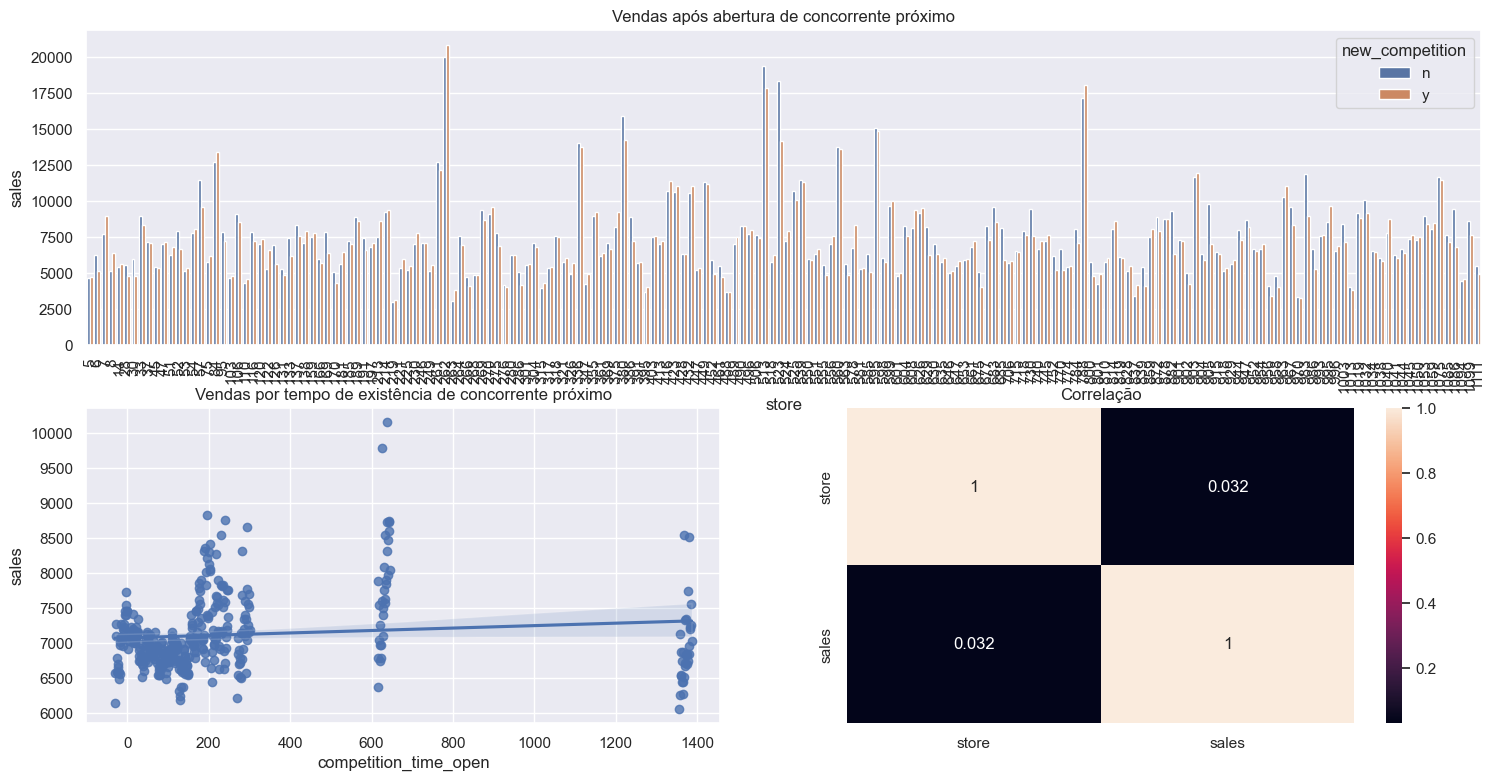

In [90]:
grid = GridSpec(2, 2)

plt.subplot(grid[0,:])
stores_with_new_competition = data3[data3['new_competition'] == 'y']['store'].unique()
aux = data3[data3['store'].isin(stores_with_new_competition)]
h1 = aux[['store','sales', 'new_competition']].groupby(['store', 'new_competition']).mean().reset_index(drop=False)
sns.barplot(data=h1, x='store', y='sales', hue='new_competition').set(title='Vendas após abertura de concorrente próximo')
plt.xticks(rotation=90);

plt.subplot(grid[1,0])
aux2 = data3[['sales', 'competition_time_open']].groupby('competition_time_open').mean().reset_index()
sns.regplot(data=aux2, x='competition_time_open', y='sales').set(title='Vendas por tempo de existência de concorrente próximo');

plt.subplot(grid[1, 1])
sns.heatmap(h1.corr( method='pearson'), annot=True).set(title='Correlação');

### H2. Lojas com ticket médio menor tem volume de vendas médio maior.


C:\Users\Felipe\AppData\Local\Temp\ipykernel_23036\4126749370.py:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(h2.corr( method='pearson'), annot=True).set(title='Correlação');


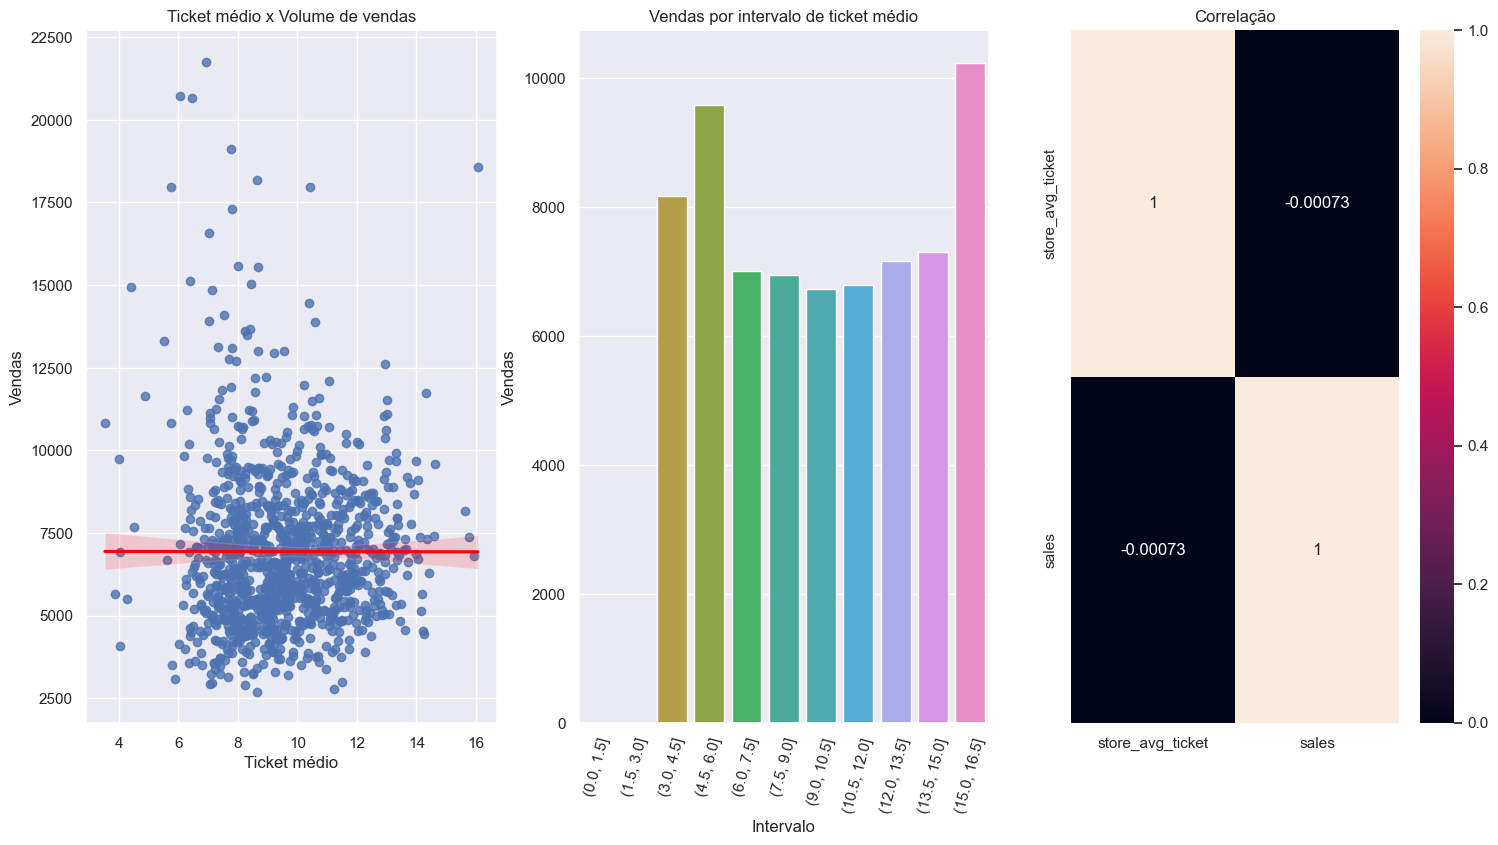

In [82]:
plt.subplot(1, 3, 1)
h2 = data3[['store_avg_ticket', 'sales']].groupby('store_avg_ticket').mean().reset_index()
sns.regplot(data=h2, y='sales', x='store_avg_ticket', line_kws={'color':'red'}).set(title='Ticket médio x Volume de vendas',
                                                                                    ylabel='Vendas',
                                                                                    xlabel='Ticket médio');
plt.subplot(1, 3, 2)
bins = list(np.arange( 0.0, 18.0, 1.5))
h2['store_avg_ticket_binned'] = pd.cut(h2['store_avg_ticket'], bins=bins)
h2_aux = h2[['store_avg_ticket_binned', 'sales']].groupby('store_avg_ticket_binned').mean().reset_index()
sns.barplot(data=h2_aux, x='store_avg_ticket_binned', y='sales' ).set(title='Vendas por intervalo de ticket médio',
                                                                                    ylabel='Vendas',
                                                                                    xlabel='Intervalo')
plt.xticks(rotation=75);

plt.subplot(1, 3, 3)
sns.heatmap(h2.corr( method='pearson'), annot=True).set(title='Correlação');


### H3. Lojas com ticket médio menor tem maior número de clientes.


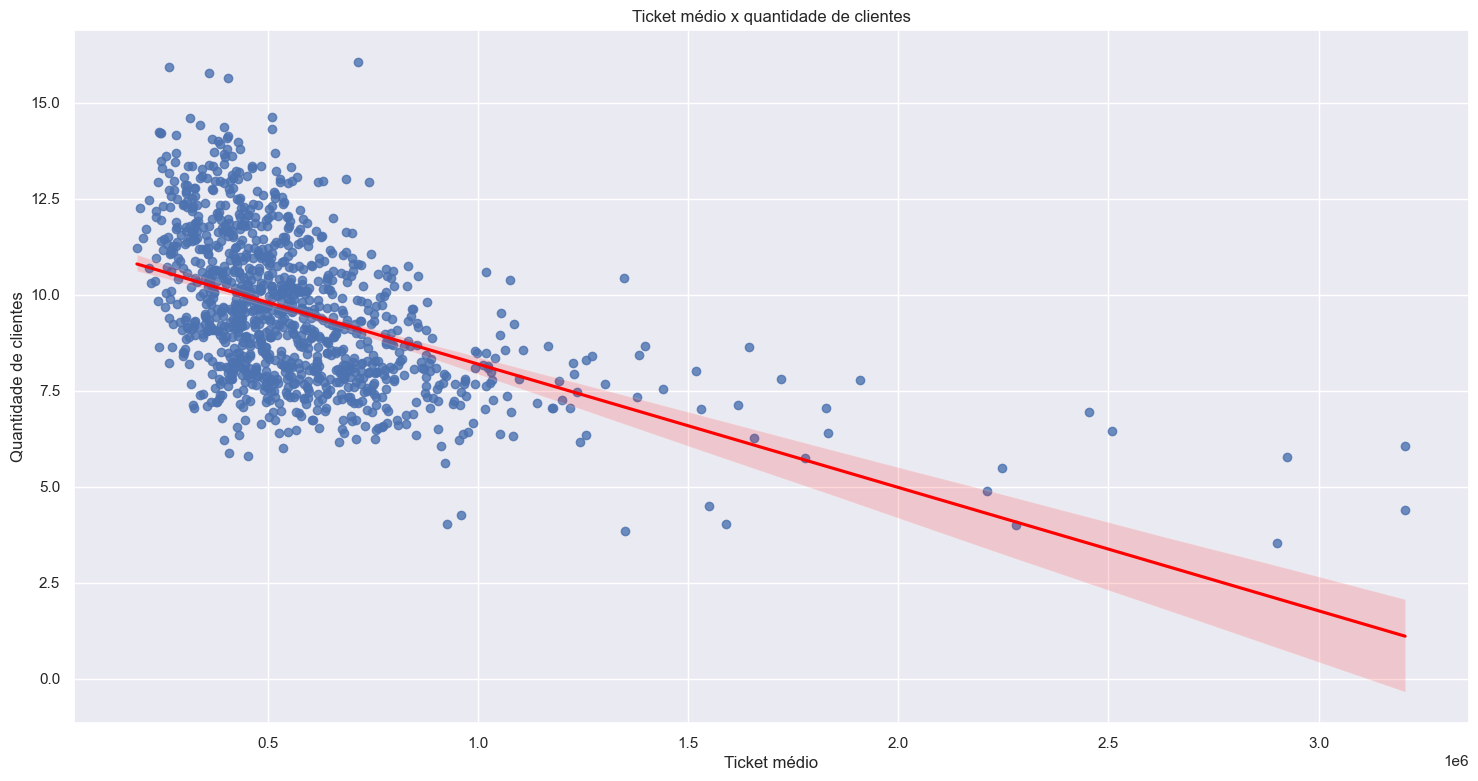

In [28]:
h3 = data3[['store_avg_ticket', 'customers']].groupby('store_avg_ticket').sum().reset_index()
sns.regplot(data=h3, x='customers', y='store_avg_ticket', line_kws={'color':'red'}).set(title='Ticket médio x quantidade de clientes',
                                                                                        ylabel='Quantidade de clientes',
                                                                                        xlabel='Ticket médio');

### H4. Lojas que participam da promoção estendida vendem mais do que aquelas que não participam.

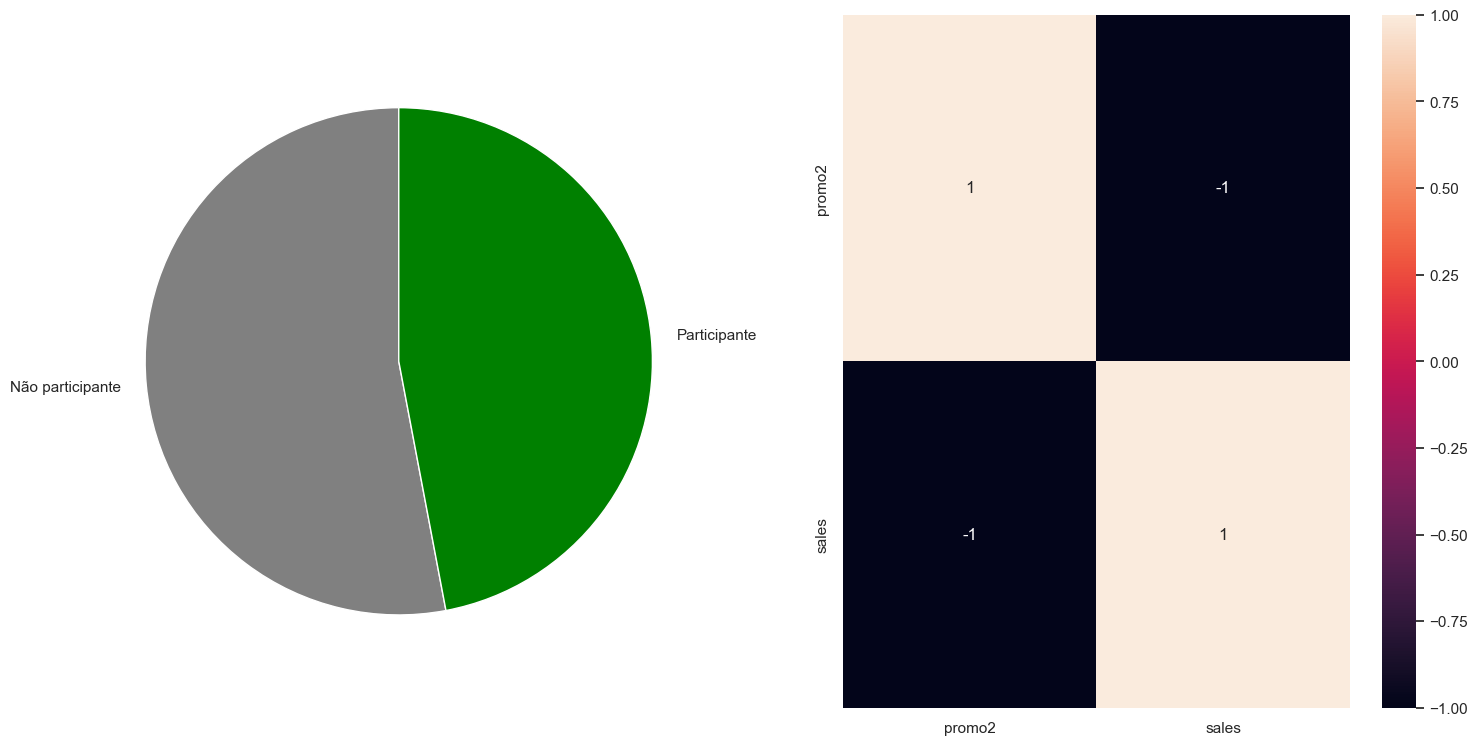

In [29]:
plt.subplot(1, 2, 1)
h4 = data3[['sales', 'promo2']].groupby('promo2').sum().reset_index()
h4['promo2'] = h4['promo2'].apply(lambda x: 'Participante' if x == 1 else 'Não participante')
plt.pie(h4['sales'], labels=h4['promo2'], startangle=90.0, colors=['gray', 'green']);

plt.subplot(1, 2, 2)
h4['promo2'] = h4['promo2'].apply(lambda x: 1 if x == 'Participante' else 0)
a = sns.heatmap(h4.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);


### H5. As lojas vendem mais durante o inverno.

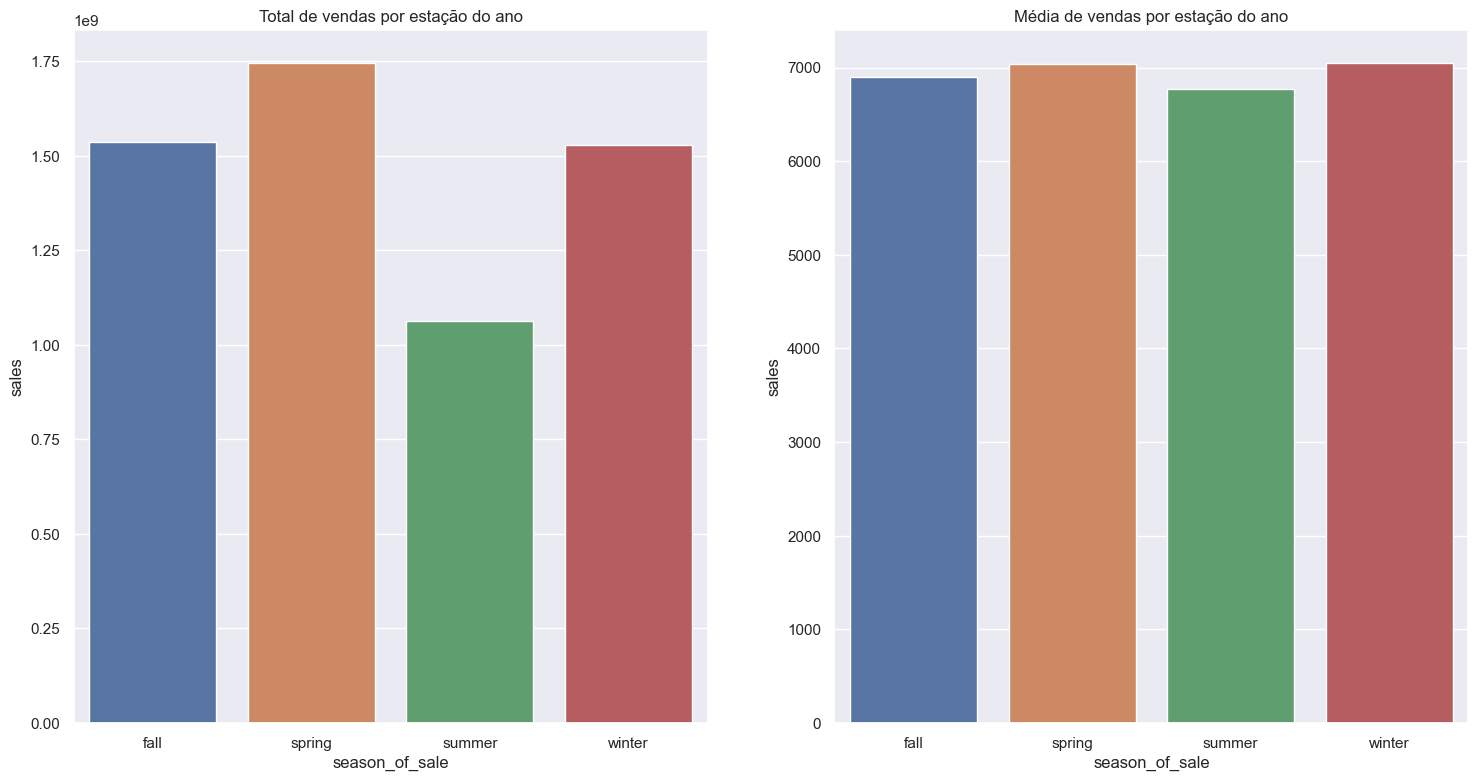

In [30]:
plt.subplot(1, 2, 1)
h5 = data3[['sales', 'season_of_sale']].groupby('season_of_sale').sum().reset_index()
sns.barplot(data=h5, x='season_of_sale', y='sales').set(title='Total de vendas por estação do ano');

plt.subplot(1, 2, 2)
h5 = data3[['sales', 'season_of_sale']].groupby('season_of_sale').mean().reset_index()
sns.barplot(data=h5, x='season_of_sale', y='sales').set(title='Média de vendas por estação do ano');

### H6. Lojas vendem mais durante os feriados escolares.

Text(0.5, 1.0, 'Total de vendas')

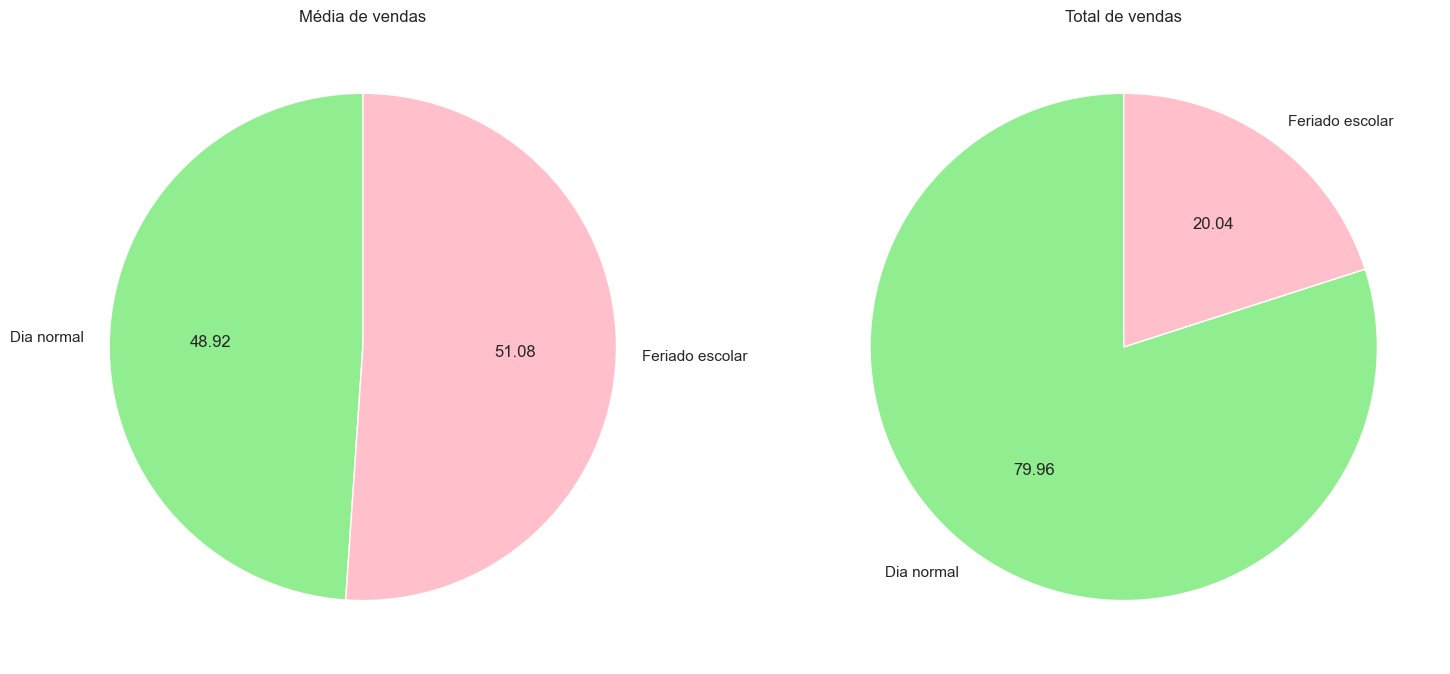

In [73]:
plt.subplot(1, 2, 1)
h6 = data3[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()
h6['school_holiday'] = h6['school_holiday'].apply(lambda x: 'Dia normal' if x == 0 else 'Feriado escolar')
plt.pie(x=h6['sales'], labels= h6['school_holiday'], startangle=90, colors=['lightgreen', 'pink'], autopct='%.2f');
plt.title('Média de vendas')

plt.subplot(1, 2, 2)
h6 = data3[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
h6['school_holiday'] = h6['school_holiday'].apply(lambda x: 'Dia normal' if x == 0 else 'Feriado escolar')
plt.pie(x=h6['sales'], labels= h6['school_holiday'], startangle=90, colors=['lightgreen', 'pink'], autopct='%.2f');
plt.title('Total de vendas')


### H7. O ticket médio de lojas com assortment mais diversificado é maior.


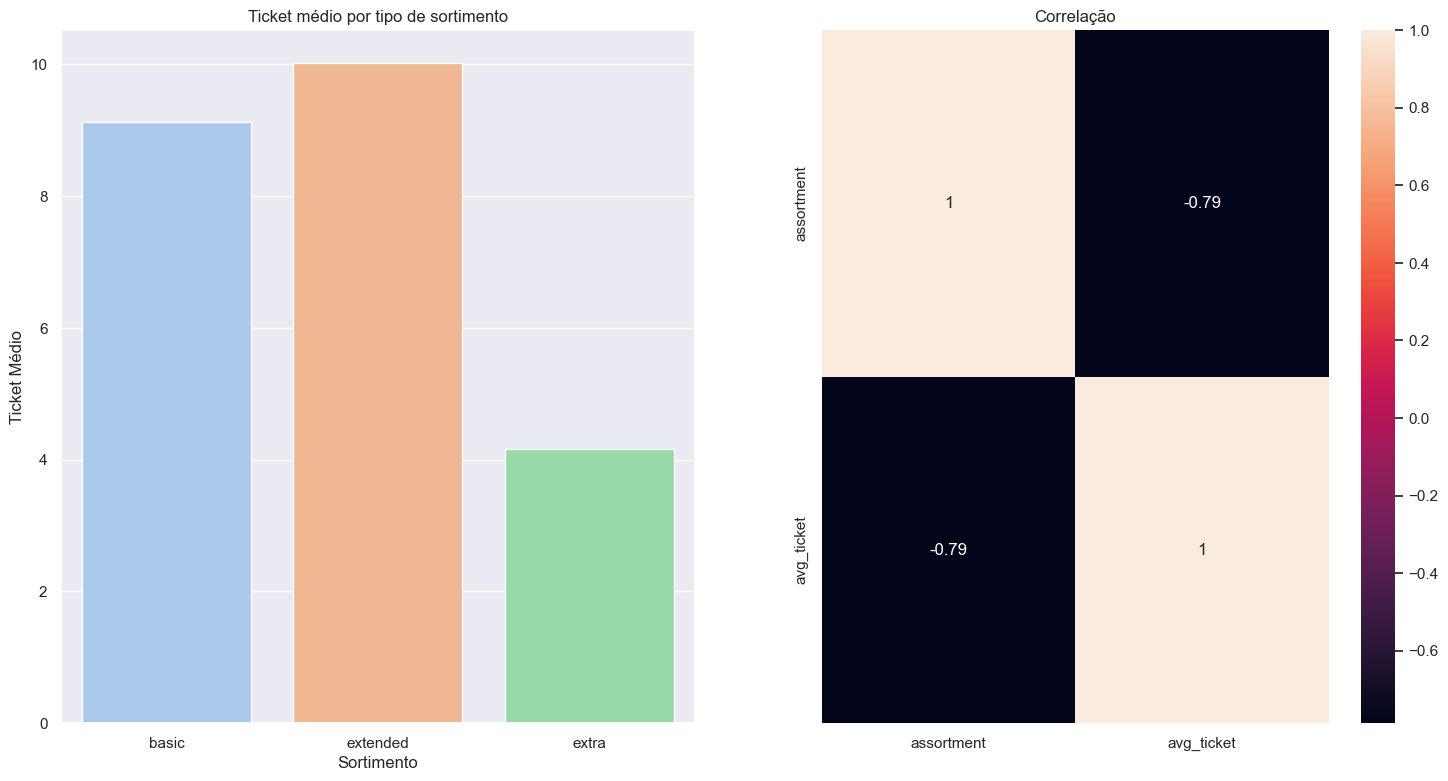

In [66]:
plt.subplot(1, 2, 1)
h7 = data3[['assortment', 'avg_ticket']].groupby('assortment').mean().reset_index()
sns.barplot(data=h7, x='assortment', y='avg_ticket', palette='pastel').set(title='Ticket médio por tipo de sortimento', 
                                                         ylabel='Ticket Médio',
                                                         xlabel='Sortimento');

plt.subplot(1, 2, 2)
assortment_map = {'basic': 1, 'extended': 2, 'extra': 3}
h7['assortment'] = h7['assortment'].map(assortment_map)
sns.heatmap(h7.corr(method='pearson'), annot=True).set(title='Correlação');

### H8. As lojas vendem mais às sextas-feiras e sábados.

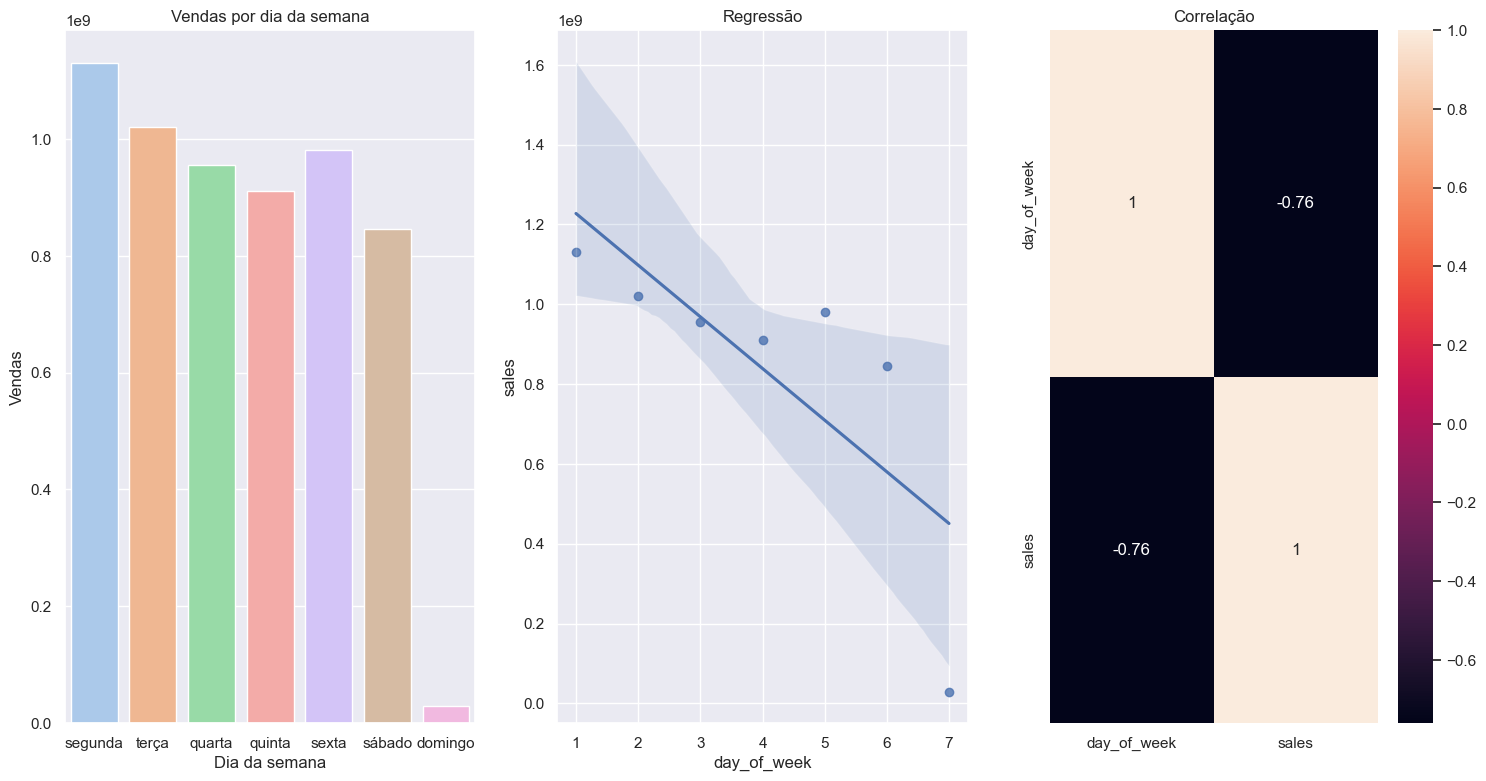

In [65]:
plt.subplot(1, 3, 1)
h8 = data3[['sales', 'day_of_week']].groupby('day_of_week').sum().reset_index()
day_dict = {1:'segunda', 2:'terça', 3:'quarta', 4:'quinta', 5:'sexta', 6:'sábado', 7:'domingo'}
h8['day_of_week'] = h8['day_of_week'].map(day_dict)
sns.barplot(data=h8, x='day_of_week', y='sales', palette='pastel').set(title='Vendas por dia da semana',
                                                     ylabel='Vendas',
                                                     xlabel='Dia da semana');

plt.subplot(1, 3, 2)
day_dict = {'segunda': 1, 'terça': 2, 'quarta': 3, 'quinta': 4, 'sexta': 5, 'sábado': 6, 'domingo': 7}
h8['day_of_week'] = h8['day_of_week'].map(day_dict)
sns.regplot(data=h8, x='day_of_week', y='sales').set(title='Regressão');

plt.subplot(1, 3, 3)
sns.heatmap(h8.corr(method='pearson'), annot=True).set(title='Correlação');

### H9. As lojas vendem mais durante o mês de início da promo2 (os meses indicados em 'promo_interval' são os iniciais).

In [34]:
aux = data3[data3['promo2'] == 1]
store_filter = widgets.Dropdown(options=list(aux['store'].unique()), description='Selecione a loja', disable=False,
                    style={'description_width' : 'initial'}, continuous_update=False, readout=True)

In [35]:
def update_filter(data3, store_filter):
    
    #Filtra
    df = data3[(data3['store'] == store_filter)].copy()
    aux = df[['sales', 'month', 'in_promo2']].groupby(['month', 'in_promo2']).sum().reset_index()
    new_order = ['Jan','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
    aux['month'] = pd.Categorical(aux['month'], categories=new_order, ordered=True)
    aux = aux.sort_values(by='month')

    #Constroi visualização
    fig = plt.figure(figsize=(24,12))
    specs = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
    ax = fig.add_subplot(specs[0,:])


    colors = ["orange" if x == 1 else "blue" for x in aux['in_promo2']]
    sns.barplot(data=aux, x='month', y='sales', ax=ax, palette=colors)
    

In [36]:
widgets.interactive(update_filter,
                    data3=fixed(data3),
                    store_filter=store_filter,)

interactive(children=(Dropdown(description='Selecione a loja', options=(2, 3, 11, 12, 13, 14, 15, 17, 18, 19, …

### H10. Lojas com maior variedade de produtos (assortment) vendem mais.

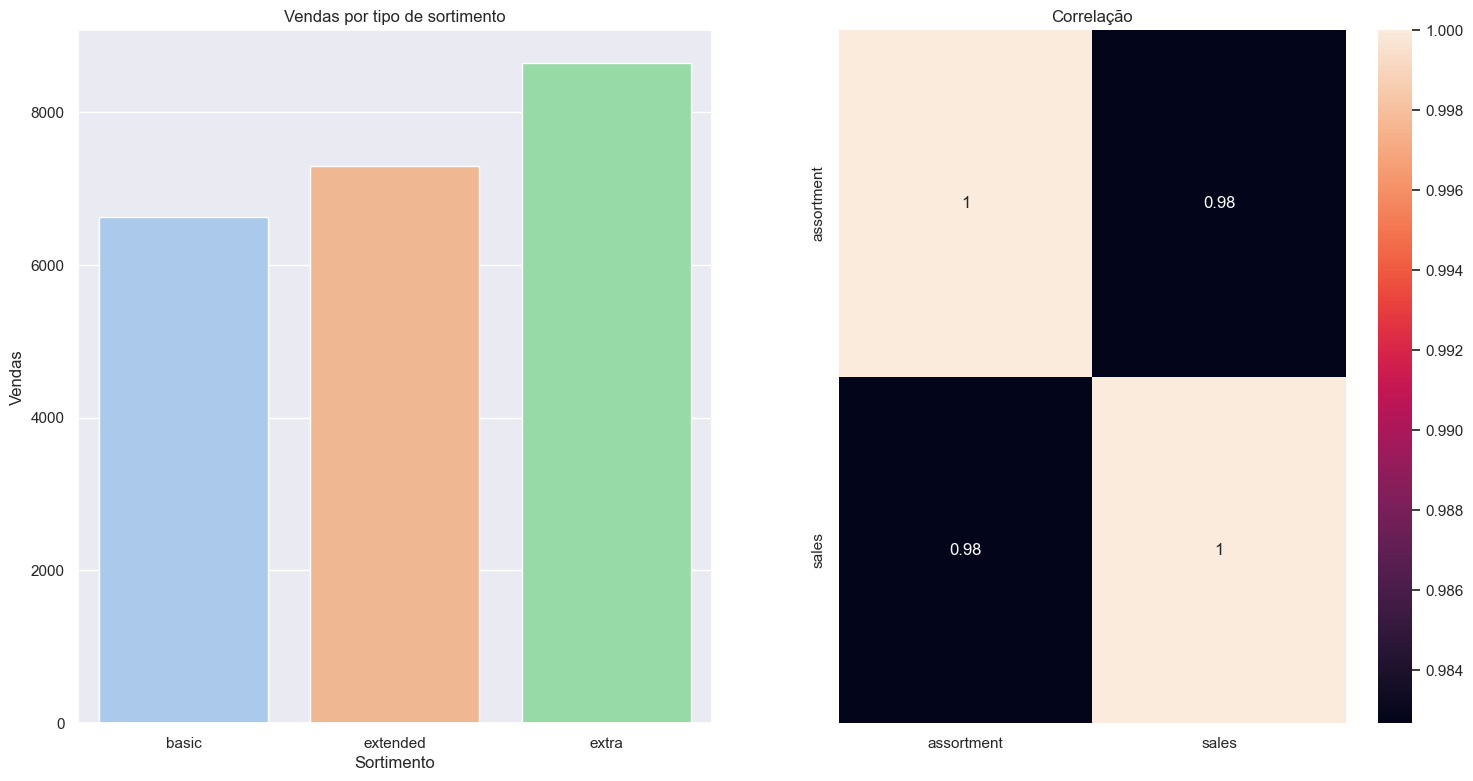

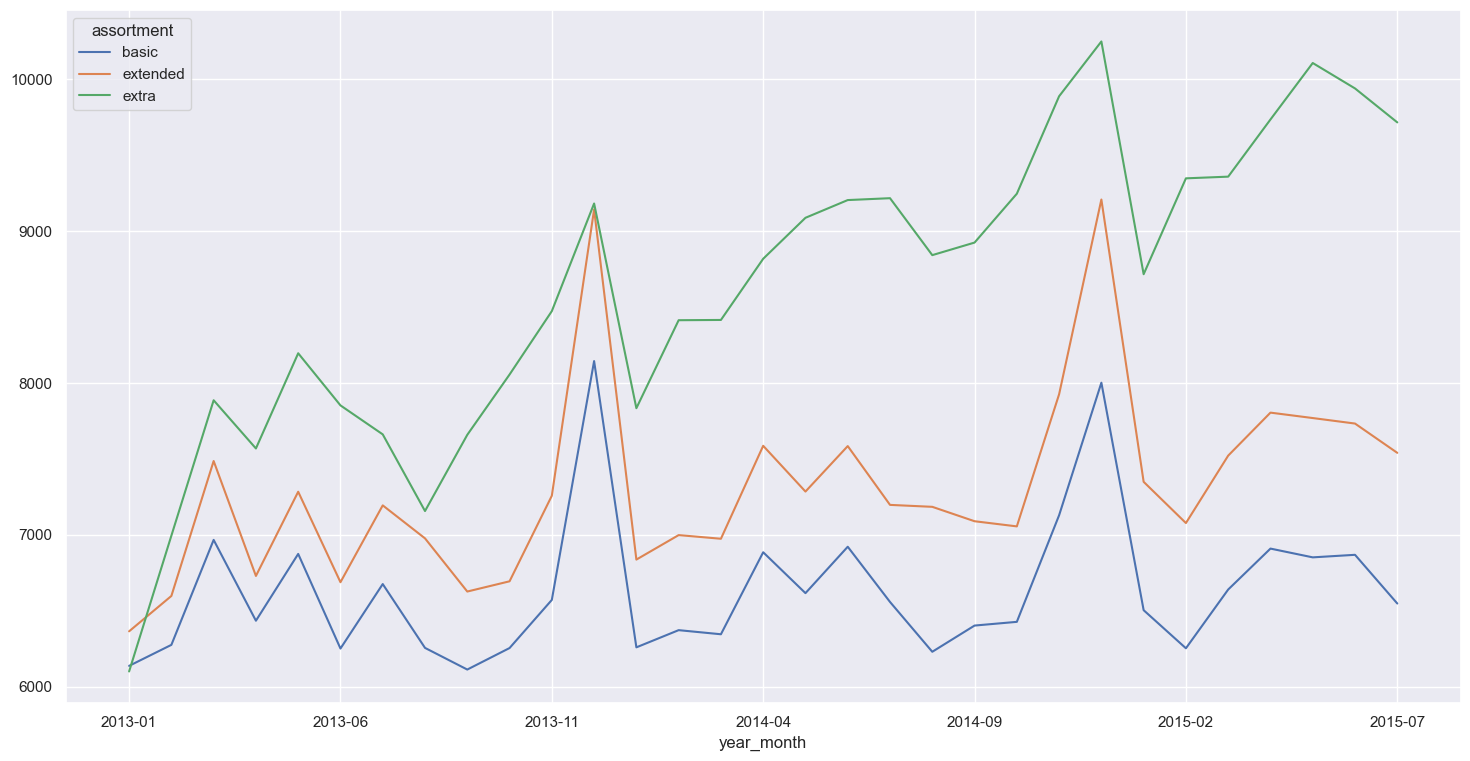

In [93]:
grid = GridSpec(1, 2)

plt.subplot(grid[0,0])
h10 = data3[['sales', 'assortment']].groupby('assortment').mean().reset_index()
sns.barplot(data=h10, x='assortment', y='sales', palette='pastel').set(title='Vendas por tipo de sortimento',
                                                     ylabel='Vendas',
                                                     xlabel='Sortimento');

plt.subplot(grid[0,1])
assortment_map = {'basic': 1, 'extended': 2, 'extra': 3}
h10['assortment'] = h10['assortment'].map(assortment_map)
sns.heatmap(h10.corr(method='pearson'), annot=True).set(title='Correlação')

h10_aux = data3.loc[:, ['sales', 'assortment', 'date']]
h10_aux['year_month'] = h10_aux['date'].dt.strftime('%Y-%m')
h10_aux2 = h10_aux[['sales', 'assortment', 'year_month']].groupby(['year_month', 'assortment']).mean().reset_index()
h10_aux2.pivot(index='year_month', columns='assortment', values='sales').plot();

### H11. A diferença entre modelos de loja (store_type) não interfere no volume médio de vendas.

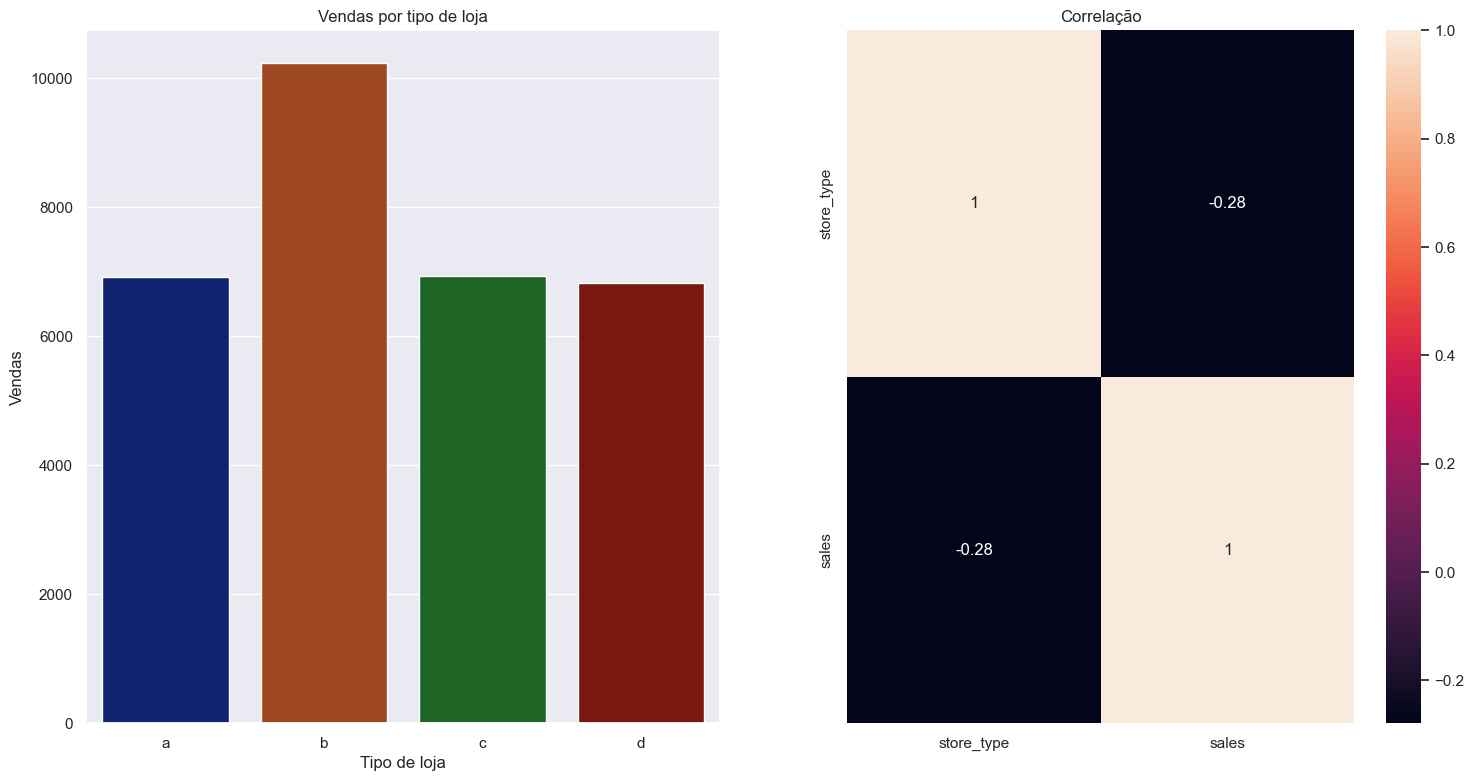

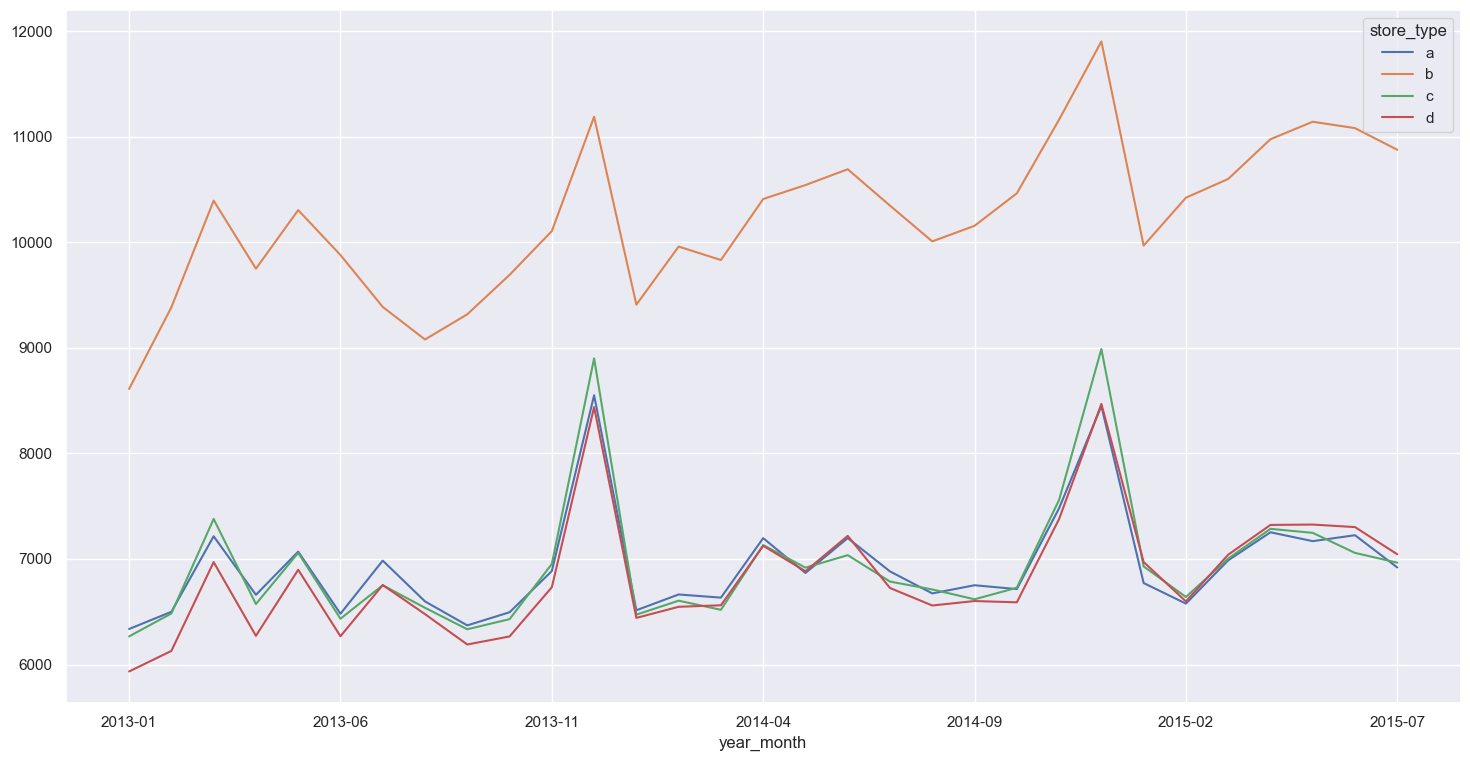

In [94]:
plt.subplot(1, 2, 1)
h11 = data3[['sales', 'store_type']].groupby('store_type').mean().reset_index()
sns.barplot(data=h11, y='sales', x='store_type', palette='dark').set(title='Vendas por tipo de loja',
                                                                     ylabel='Vendas',
                                                                     xlabel='Tipo de loja');
plt.subplot(1, 2, 2)
store_type_map = {'a': 1, 'b': 2, 'c': 3, 'd': 4 }
h11['store_type'] = h11['store_type'].map(store_type_map)
sns.heatmap(h11.corr(method='pearson'), annot=True).set(title='Correlação');


h11_aux = data3.loc[:, ['sales', 'store_type', 'date']]
h11_aux['year_month'] = h11_aux['date'].dt.strftime('%Y-%m')
h11_aux2 = h11_aux[['sales', 'store_type', 'year_month']].groupby(['year_month', 'store_type']).mean().reset_index()
h11_aux2.pivot(index='year_month', columns='store_type', values='sales').plot();

### H12. Lojas com sortimento mais simples tem menor número de clientes.

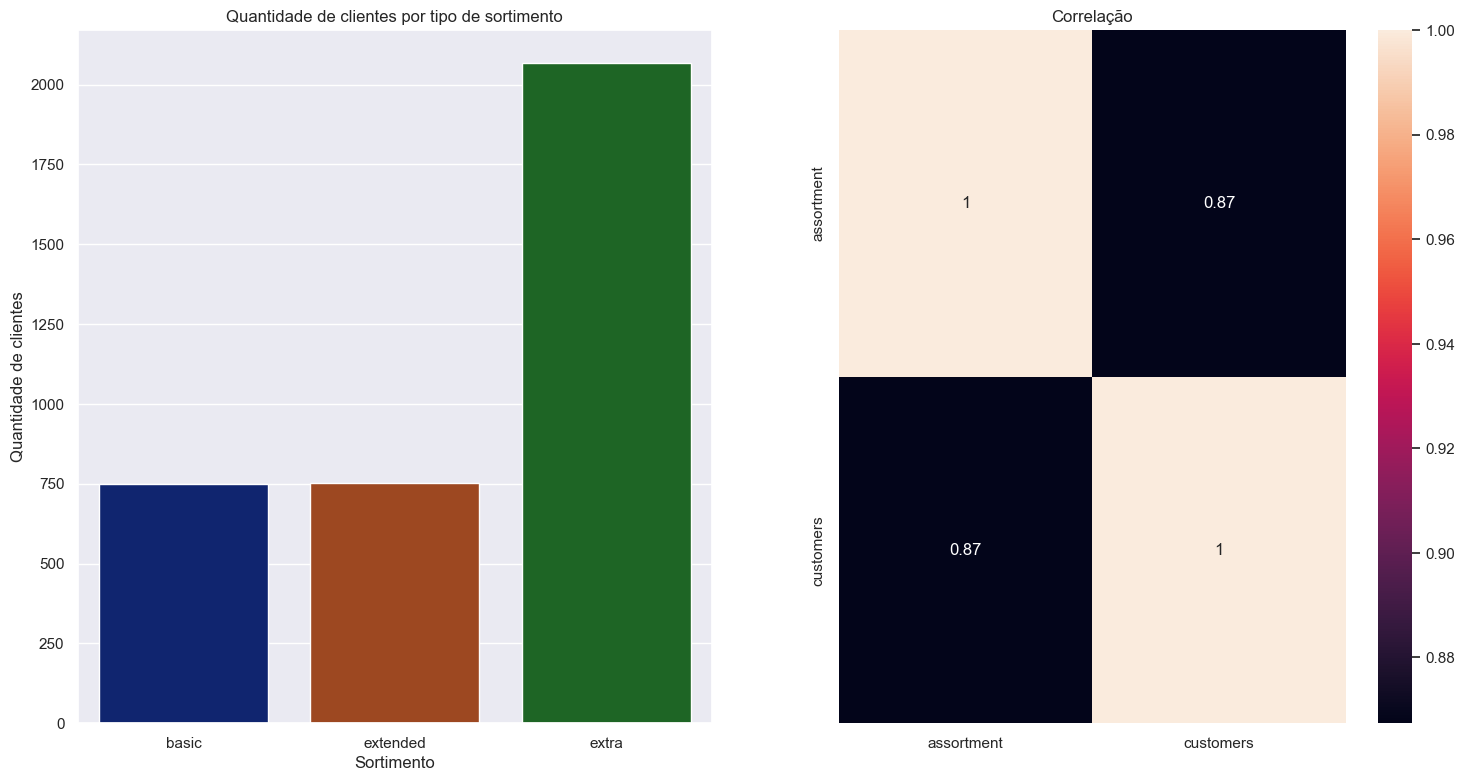

In [64]:
plt.subplot(1, 2, 1)
h12 = data3[['assortment', 'customers']].groupby('assortment').mean().reset_index()
sns.barplot(data=h12, x='assortment', y='customers', palette='dark').set(title='Quantidade de clientes por tipo de sortimento',
                                                                         ylabel='Quantidade de clientes',
                                                                         xlabel='Sortimento');

plt.subplot(1, 2, 2)
assortment_map = {'basic': 1, 'extended': 2, 'extra': 3}
h12['assortment'] = h12['assortment'].map(assortment_map)
sns.heatmap(h12.corr(method='pearson'), annot=True).set(title='Correlação');

## Resumo das hipóteses

In [95]:
hr = [['Hipótese', 'Resultado', 'Relevância'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Baixa'],
['H3', 'Verdadeira', 'Alta'],
['H4', 'Falsa', 'Alta'],
['H5', 'Falsa', 'Média'],
['H6', 'Verdadeira', 'Média'],
['H7', 'Falsa', 'Alta'],
['H8', 'Falsa', 'Alta'],
['H9', 'Inconclusiva', '-'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Falsa', 'Média'],
['H12', 'Verdadeira', 'Alta']]

print(tabulate(hr, headers='firstrow'))

Hipótese    Resultado     Relevância
----------  ------------  ------------
H1          Falsa         Baixa
H2          Falsa         Baixa
H3          Verdadeira    Alta
H4          Falsa         Alta
H5          Falsa         Média
H6          Verdadeira    Média
H7          Falsa         Alta
H8          Falsa         Alta
H9          Inconclusiva  -
H10         Verdadeira    Alta
H11         Falsa         Média
H12         Verdadeira    Alta


## 3.3 Análise Multivariada

### 3.3.1 Numerical Attributes

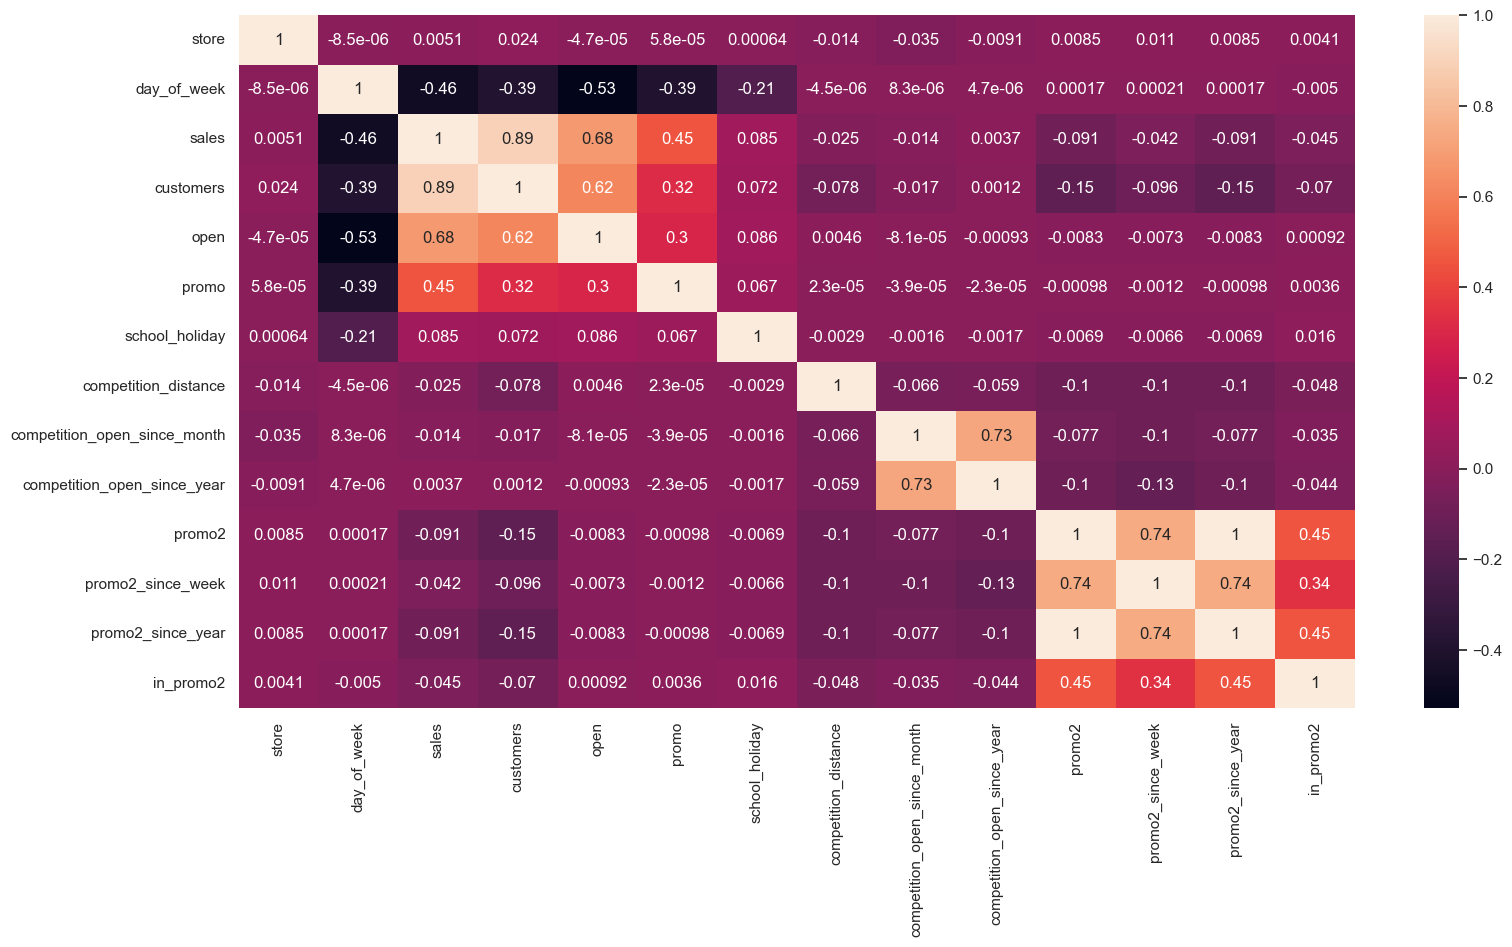

In [96]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 3.3.2 Categorical Attributes

In [97]:
# new categorical data
a = data3.select_dtypes(include='object')

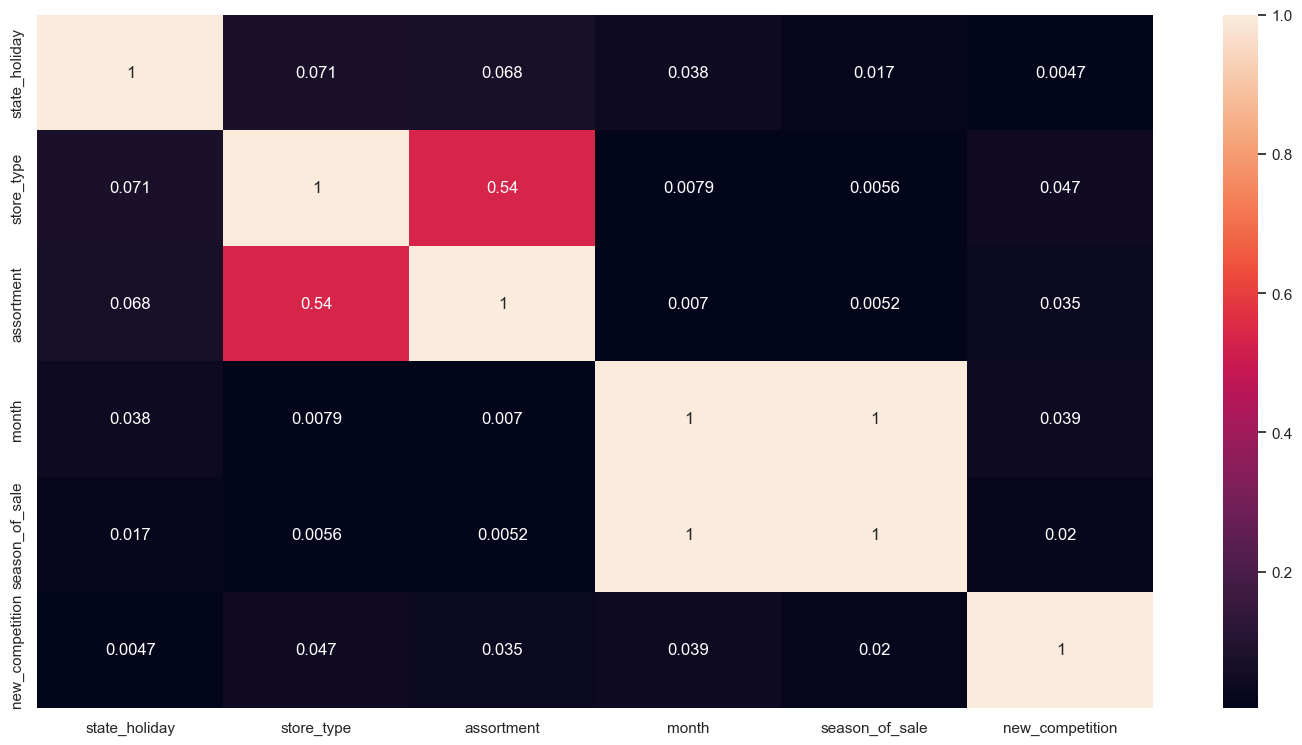

In [98]:
# Calculate Cramer_v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])
a4 = cramer_v(a['state_holiday'], a['month'])
a5 = cramer_v(a['state_holiday'], a['season_of_sale'])
a6 = cramer_v(a['state_holiday'], a['new_competition'])

b1 = cramer_v(a['store_type'], a['state_holiday'])
b2 = cramer_v(a['store_type'], a['store_type'])
b3 = cramer_v(a['store_type'], a['assortment'])
b4 = cramer_v(a['store_type'], a['month'])
b5 = cramer_v(a['store_type'], a['season_of_sale'])
b6 = cramer_v(a['store_type'], a['new_competition'])

c1 = cramer_v(a['assortment'], a['state_holiday'])
c2 = cramer_v(a['assortment'], a['store_type'])
c3 = cramer_v(a['assortment'], a['assortment'])
c4 = cramer_v(a['assortment'], a['month'])
c5 = cramer_v(a['assortment'], a['season_of_sale'])
c6 = cramer_v(a['assortment'], a['new_competition'])

d1 = cramer_v(a['month'], a['state_holiday'])
d2 = cramer_v(a['month'], a['store_type'])
d3 = cramer_v(a['month'], a['assortment'])
d4 = cramer_v(a['month'], a['month'])
d5 = cramer_v(a['month'], a['season_of_sale'])
d6 = cramer_v(a['month'], a['new_competition'])

e1 = cramer_v(a['season_of_sale'], a['state_holiday'])
e2 = cramer_v(a['season_of_sale'], a['store_type'])
e3 = cramer_v(a['season_of_sale'], a['assortment'])
e4 = cramer_v(a['season_of_sale'], a['month'])
e5 = cramer_v(a['season_of_sale'], a['season_of_sale'])
e6 = cramer_v(a['season_of_sale'], a['new_competition'])

f1 = cramer_v(a['new_competition'], a['state_holiday'])
f2 = cramer_v(a['new_competition'], a['store_type'])
f3 = cramer_v(a['new_competition'], a['assortment'])
f4 = cramer_v(a['new_competition'], a['month'])
f5 = cramer_v(a['new_competition'], a['season_of_sale'])
f6 = cramer_v(a['new_competition'], a['new_competition'])

# final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3, a4, a5, a6],
                  'store_type': [b1, b2, b3, b4, b5, b6],
                  'assortment': [c1, c2, c3, c4, c5, c6],
                  'month': [d1, d2, d3, d4, d5, d6],
                  'season_of_sale': [e1, e2, e3, e4, e5, e6],
                  'new_competition': [f1, f2, f3, f4, f5, f6]})
d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

# 4. Preparação dos dados

In [99]:
data4 = data3.copy()

## 4.1 Normalização

## 4.2 Rescaling

In [100]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition time open minmax
data4['competition_time_open'] = mms.fit_transform(data4[['competition_time_open']].values)

# year minmax
data4['year'] = mms.fit_transform(data4[['year']].values)

# store avg ticket minmax
data4['store_avg_ticket'] = mms.fit_transform(data4[['store_avg_ticket']].values)

# competition distante robust
data4['competition_distance'] = rs.fit_transform(data4[['competition_distance']])

# customers robust
data4['customers'] = rs.fit_transform(data4[['customers']])

# avg Ticket robust
data4['avg_ticket'] = rs.fit_transform(data4[['avg_ticket']])


## 4.3 Transformação

### 4.3.1 Encoding

In [101]:
# state holiday - one hot encoding
data4 = pd.get_dummies(data4, prefix=['state_holiday'], columns=['state_holiday'])

# store type - label
le = LabelEncoder()
data4['store_type'] = le.fit_transform(data4['store_type'])

# assortment - ordinal encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
data4['assortment'] = data4['assortment'].map(assortment_dict)

# season of sale - ordinal
season_dict = {'winter': 1, 'spring': 2, 'summer': 3, 'fall': 4}
data4['season_of_sale'] = data4['season_of_sale'].map(season_dict)

# new competition - label
data4['new_competition'] = le.fit_transform(data4['new_competition'])

### 4.3.2 Response variable transformation

In [102]:
data4['sales'] = np.log1p(data4['sales'])

### 4.3.3 Nature Transformation

In [103]:
# day of week
data4['day_of_week_sin'] = data4['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
data4['day_of_week_cos'] = data4['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
month_dict2 = {'Jan': 1,'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 
               'Jul': 7, 'Aug': 8, 'Sept': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
data4['month'] = data4['month'].map(month_dict2)

data4['month_sin'] = data4['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
data4['month_cos'] = data4['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
data4['day_sin'] = data4['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
data4['day_cos'] = data4['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))


# 5. Feature Selection

In [104]:
data5 = data4.copy()

## 5.1 Split dataframe into training and test

In [49]:
cols_to_drop2 = ['day', 'month', 'day_of_week']
data5 = data5.drop(cols_to_drop2, axis=1)

In [50]:
# training dataset
X_train = data5[data5['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = data5[data5['date'] >= '2015-06-19']
y_test = X_test['sales']

print(f'Training min date {X_train["date"].min()}')
print(f'Training min date {X_train["date"].max()}')
print(f'\nTraining min date {X_test["date"].min()}')
print(f'Training min date {X_test["date"].max()}')

Training min date 2013-01-01 00:00:00
Training min date 2015-06-18 00:00:00

Training min date 2015-06-19 00:00:00
Training min date 2015-07-31 00:00:00


## 5.2 Boruta as feature selection

In [51]:
# alguns NA resisuais em avg_ticket em decorrência de sales estar zerado para aquela observação.
X_train['avg_ticket'] = X_train['avg_ticket'].apply(lambda x: 0 if math.isnan(x) else x)

C:\Users\Felipe\AppData\Local\Temp\ipykernel_8288\2032742284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['avg_ticket'] = X_train['avg_ticket'].apply(lambda x: 0 if math.isnan(x) else x)


In [53]:
# training and test for Boruta (vetorizado)
X_train_n = X_train.drop(['date', 'sales', 'avg_ticket', 'store_avg_ticket', 'competition_open'], axis=1).values
y_train_n = y_train.values.ravel()

rf = RandomForestRegressor(n_jobs=-1)

boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	0
Rejected: 	12


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	0
Rejected: 	12


In [55]:
cols_selected = boruta.support_.tolist()

X_train_fs = X_train.drop(['date', 'sales', 'competition_open', 'avg_ticket', 'store_avg_ticket'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

cols_not_selected_boruta = list(np.setdiff1d(X_train_fs, cols_selected_boruta))

c:\Users\Felipe\anaconda3\envs\rossmann\lib\site-packages\numpy\lib\arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [57]:
df1 = pd.DataFrame(cols_selected_boruta)
df2 = pd.DataFrame(cols_not_selected_boruta)
df1.to_csv('c:\\Users\\Felipe\\Desktop\\repos\\projetos\\rossmann_sales_predict\\selecao_boruta.csv', index=False)
df2.to_csv('c:\\Users\\Felipe\\Desktop\\repos\\projetos\\rossmann_sales_predict\\descarte_boruta.csv', index=False)

In [56]:
cols_selected_boruta

['store',
 'customers',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'promo2',
 'competition_time_open',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_cos']

## 5.3 Manual feature selection

In [106]:
cols_selected_boruta = ['store',
'customers',
'promo',
'store_type',
'assortment',
'competition_distance',
'promo2',
'competition_time_open',
'day_of_week_sin',
'day_of_week_cos',
'month_cos',
'day_cos']

cols_to_add = ['sales', 'date', 'season_of_sale', 'school_holiday', 'month_sin', 'day_sin']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(cols_to_add)